In [1]:
# 📦 Step 1: Load & Clean Data

import pandas as pd
import numpy as np
import glob
import os
from collections import defaultdict
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
import seaborn as sns

# Load all CSVs
data_path = "./tennis_atp-master/"
all_files = glob.glob(os.path.join(data_path, "atp_matches_*.csv"))

dfs = []
for filename in all_files:
    df = pd.read_csv(filename)
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
print(f"✅ Loaded {df.shape[0]:,} matches")

# Clean data
df = df[["tourney_date", "surface", "winner_name", "loser_name",
         "winner_rank", "loser_rank", "winner_age", "loser_age",
         "winner_ht", "loser_ht"]].dropna()
df["tourney_date"] = pd.to_datetime(df["tourney_date"], format='%Y%m%d')
df = df.sort_values("tourney_date").reset_index(drop=True)


/var/folders/wp/s941m0l15zj059106q_myt1r0000gn/T/ipykernel_19452/392241221.py:23: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename)


✅ Loaded 968,048 matches


In [2]:
# 🧮 Step 2: Feature Engineering

from collections import defaultdict
from datetime import timedelta
import numpy as np

# — init histories —
elo = defaultdict(lambda: 1500)
surface_elo = defaultdict(lambda: {"Hard": 1500, "Clay": 1500, "Grass": 1500})

# now surface‑specific H2H: key = (playerA, playerB, surface)
surf_h2h = defaultdict(lambda: [0, 0])  # [wins for A, wins for B]

last_match = {}
elo_hist = defaultdict(list)

# storage
X, y = [], []

K = 32
VALID_SURF = {"Hard", "Clay", "Grass"}

for _, row in df.iterrows():
    w, l = row["winner_name"], row["loser_name"]
    surface = row["surface"]
    date = row["tourney_date"]
    if surface not in VALID_SURF:
        continue

    # --- Elo features ---
    e_w, e_l = elo[w], elo[l]
    s_e_w = surface_elo[w][surface]
    s_e_l = surface_elo[l][surface]

    # --- Surface-specific H2H ---
    h_w, h_l = surf_h2h[(w, l)]
    total = h_w + h_l
    surf_h2h_pct = h_w/total if total>0 else 0.5

    # --- Rest days ---
    rest_w = min((date - last_match.get(w, date - timedelta(days=5))).days, 14)
    rest_l = min((date - last_match.get(l, date - timedelta(days=5))).days, 14)


    # --- Recent form (last 5 Elo) ---
    rec_w = np.mean(elo_hist[w][-5:]) if len(elo_hist[w])>=5 else elo[w]
    rec_l = np.mean(elo_hist[l][-5:]) if len(elo_hist[l])>=5 else elo[l]

    # --- Age & Height diffs ---
    age_diff   = row["winner_age"] - row["loser_age"]
    height_diff= row["winner_ht"]   - row["loser_ht"]

    # build feature vector for winner-perspective
    feats = {
        "elo_diff":           e_w - e_l,
        "surface_elo_diff":   s_e_w - s_e_l,
        "rank_diff":          row["loser_rank"] - row["winner_rank"],
        "surf_h2h_pct":       surf_h2h_pct,
        "age_diff":           age_diff,
        "height_diff":        height_diff,
        "recent_form_diff":   rec_w - rec_l,
        "rest_advantage":     int(rest_w > rest_l)
    }

    X.append(list(feats.values()))
    y.append(1)

    # flipped (loser wins) — same transformations
    flip = {k: -v if k.endswith("_diff") else (1-v if k=="surf_h2h_pct" else v)
            for k,v in feats.items()}

    X.append(list(flip.values()))
    y.append(0)

    # — update histories AFTER feature capture —
    # overall Elo
    exp  = 1/(1+10**((e_l - e_w)/400))
    elo[w] += K*(1-exp)
    elo[l] -= K*(1-exp)

    # surface Elo
    exp_s= 1/(1+10**((s_e_l - s_e_w)/400))
    surface_elo[w][surface] += K*(1-exp_s)
    surface_elo[l][surface] -= K*(1-exp_s)

    # surface H2H
    surf_h2h[(w, l)][0] += 1
    surf_h2h[(l, w)][1] += 1

    # rest & rec history
    last_match[w] = last_match[l] = date
    elo_hist[w].append(elo[w])
    elo_hist[l].append(elo[l])


In [3]:
# 🧠 Step 3: Train/Test Split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
feature_names = [
        "elo_diff",
        "surface_elo_diff",
        "rank_diff",
        "surf_h2h_pct",
        "age_diff",
        "height_diff",
        "recent_form_diff",
        "rest_advantage"
        ]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=42
)




📊 Decision Tree Accuracy: 0.6459
🔍 ROC AUC: 0.7036
📉 Confusion Matrix:
 [[50747 27654]
 [27846 50494]]


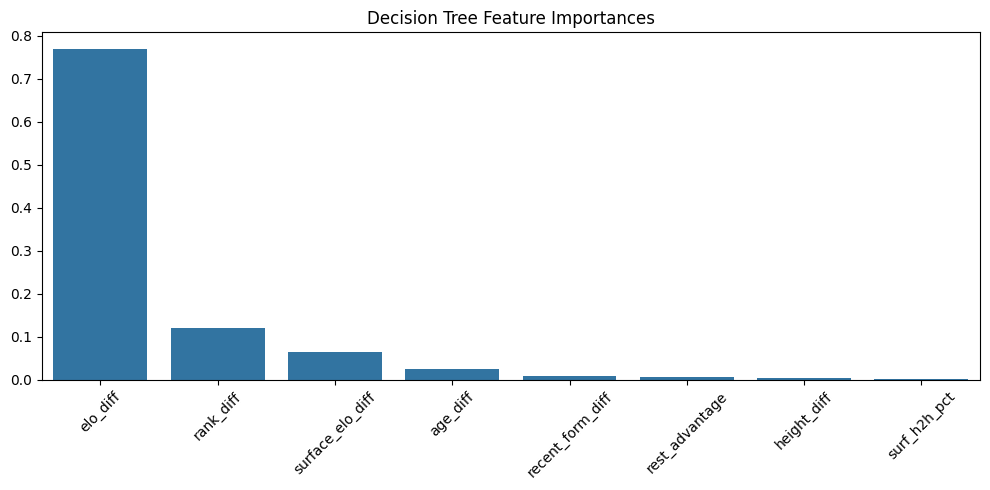


📊 Random Forest Accuracy: 0.6499
🔍 ROC AUC: 0.7093
📉 Confusion Matrix:
 [[51201 27200]
 [27673 50667]]


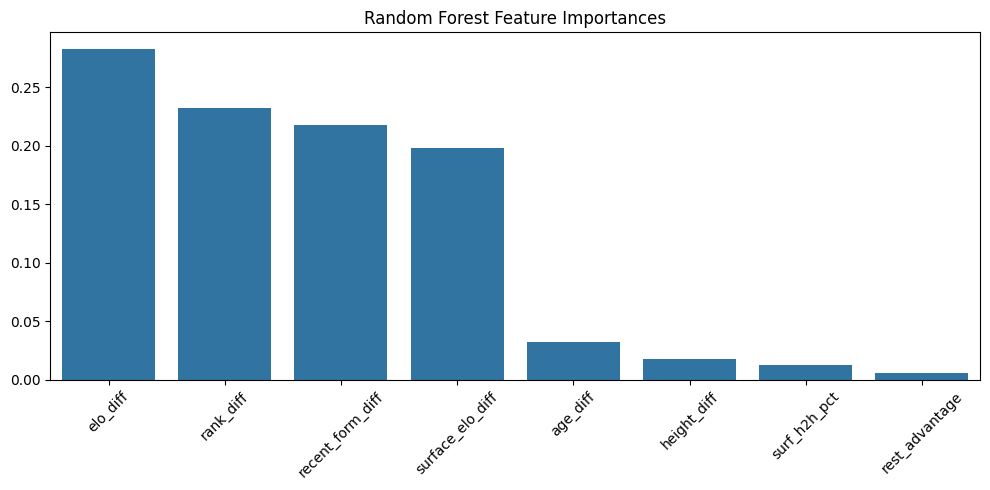

/Users/mehmet/.pyenv/versions/3.11.13/envs/env3.11.13/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [16:25:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 XGBoost Accuracy: 0.6506
🔍 ROC AUC: 0.7104
📉 Confusion Matrix:
 [[51116 27285]
 [27484 50856]]


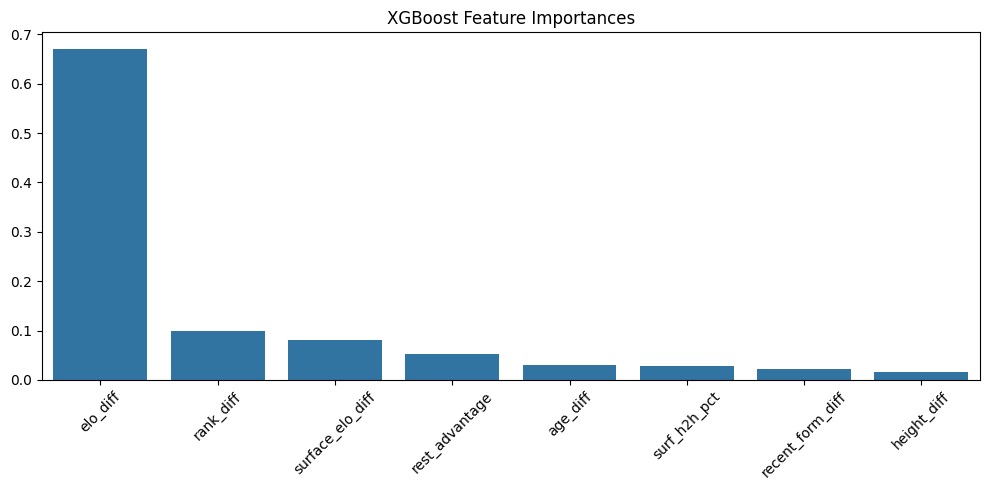

In [4]:

# 🤖 Step 4: Train & Evaluate Models: 

decisiontree = DecisionTreeClassifier(max_depth=10, random_state=42)
randomforest = RandomForestClassifier(n_estimators=300, max_depth=12, random_state=42)
xgboost = XGBClassifier(use_label_encoder=False, eval_metric='logloss', max_depth=6, learning_rate=0.1, n_estimators=300, random_state=42)

models = {
    "Decision Tree": decisiontree,
    "Random Forest": randomforest,
    "XGBoost": xgboost
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n📊 {name} Accuracy: {acc:.4f}")
    print(f"🔍 ROC AUC: {auc:.4f}")
    print("📉 Confusion Matrix:\n", cm)

    # Plot feature importances
    importances = model.feature_importances_
    sorted_idx = np.argsort(importances)[::-1]
    plt.figure(figsize=(10, 5))
    plt.title(f"{name} Feature Importances")
    sns.barplot(x=np.array(feature_names)[sorted_idx], y=importances[sorted_idx])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



In [5]:
# 🔍 Step 4b: Permutation Importance to Rank Features

from sklearn.inspection import permutation_importance

for name, model in models.items():
    print(f"\n🔍 Permutation Importance for {name}")
    perm = permutation_importance(
        model,
        X_test,
        y_test,
        scoring="accuracy",
        n_repeats=10,
        random_state=42
    )
    importances = perm.importances_mean
    for feat, imp in sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True):
        print(f"{feat:>20}: Δaccuracy = {imp:.4f}")


🔍 Permutation Importance for Decision Tree
            elo_diff: Δaccuracy = 0.0652
    surface_elo_diff: Δaccuracy = 0.0408
           rank_diff: Δaccuracy = 0.0325
    recent_form_diff: Δaccuracy = 0.0056
            age_diff: Δaccuracy = 0.0031
      rest_advantage: Δaccuracy = 0.0006
        surf_h2h_pct: Δaccuracy = 0.0003
         height_diff: Δaccuracy = 0.0000

🔍 Permutation Importance for Random Forest
    surface_elo_diff: Δaccuracy = 0.0239
           rank_diff: Δaccuracy = 0.0234
            elo_diff: Δaccuracy = 0.0226
            age_diff: Δaccuracy = 0.0020
    recent_form_diff: Δaccuracy = 0.0017
      rest_advantage: Δaccuracy = 0.0007
        surf_h2h_pct: Δaccuracy = 0.0006
         height_diff: Δaccuracy = -0.0000

🔍 Permutation Importance for XGBoost
            elo_diff: Δaccuracy = 0.1193
    surface_elo_diff: Δaccuracy = 0.0393
           rank_diff: Δaccuracy = 0.0275
    recent_form_diff: Δaccuracy = 0.0164
            age_diff: Δaccuracy = 0.0036
      rest_a

In [6]:
# 🏆 Step 5: Predict Wimbledon Champion

import random
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import math
from datetime import datetime, timedelta

# Load player data from CSV files
qualifying_path = "./wimbledon2024_quali.csv"
main_draw_path = "./wimbledon2024_main.csv"

# Load qualifying players
qualifying_df = pd.read_csv(qualifying_path)
print(f"Loaded {len(qualifying_df)} qualifying players")

# Load main draw players
main_draw_df = pd.read_csv(main_draw_path)
print(f"Loaded {len(main_draw_df)} main draw players")

# Simulate qualifying tournament (16 players qualify from 128)
def simulate_qualifying(qualifying_players, model):
    print("Simulating qualifying tournament...")
    qualifiers = []
    
    # Group qualifying players into sections (typically 16 sections of 8 players)
    num_sections = 16
    players_per_section = len(qualifying_players) // num_sections
    
    for section in range(num_sections):
        section_start = section * players_per_section
        section_end = (section + 1) * players_per_section
        section_players = qualifying_players[section_start:section_end]
        
        # Run 3 rounds of qualifying in this section
        remaining_players = section_players
        for round_num in range(3):  # 3 qualifying rounds
            winners = []
            for i in range(0, len(remaining_players), 2):
                if i+1 < len(remaining_players):
                    p1 = remaining_players[i]
                    p2 = remaining_players[i+1]
                    winner = simulate_match(p1, p2, model)
                    winners.append(winner)
                else:
                    winners.append(remaining_players[i])  # Odd player gets a bye
            remaining_players = winners
        
        # Last player standing qualifies
        qualifiers.append(remaining_players[0])
    
    print(f"Qualifying complete. {len(qualifiers)} players advanced to main draw.")
    return qualifiers

# Function to process player data and add necessary information
def process_player_data(player_df):
    # Extract player names and match with our dataset
    processed_players = []
    
    for _, row in player_df.iterrows():
        player_name = row['player_name']
        
        # Find player in our dataset (assuming df has player info)
        player_info = df[df['winner_name'] == player_name].iloc[-1:] if len(df[df['winner_name'] == player_name]) > 0 else \
                     df[df['loser_name'] == player_name].iloc[-1:]
        
        if len(player_info) == 0:
            # Player not found in dataset, use defaults
            player = {
                "name": player_name,
                "rank": row.get('rank', 100),  # Use CSV rank if available, else default
                "age": row.get('age', 25),     # Use CSV age if available, else default
                "height": row.get('height', 185),  # Use CSV height if available, else default
                "is_bye": False
            }
        else:
            # Player found in dataset
            is_winner = player_info['winner_name'].iloc[0] == player_name
            player = {
                "name": player_name,
                "rank": player_info['winner_rank' if is_winner else 'loser_rank'].iloc[0],
                "age": player_info['winner_age' if is_winner else 'loser_age'].iloc[0],
                "height": player_info['winner_ht' if is_winner else 'loser_ht'].iloc[0],
                "is_bye": False
            }
        
        processed_players.append(player)
    
    return processed_players

# Process player data
qualifying_players = process_player_data(qualifying_df)
main_draw_players = process_player_data(main_draw_df)

# Make sure we have a power of 2 for tournament bracket
def pad_to_power_of_two(players_list):
    n = len(players_list)
    next_power = 2**math.ceil(math.log2(n))
    
    # Add bye players to fill tournament bracket
    if n < next_power:
        for i in range(next_power - n):
            players_list.append({
                "name": f"Bye_{i+1}", 
                "rank": 9999,
                "age": 25.0,
                "height": 185,
                "is_bye": True  # Flag to identify bye players
            })
    
    return players_list

# Function to generate features for a match
def generate_match_features(player1, player2, surface="Grass"):
    # Access the global dictionaries created during training
    # If player not in dictionaries, use default values
    
    # Get ELO values (or defaults)
    p1_elo = elo.get(player1["name"], 1500)
    p2_elo = elo.get(player2["name"], 1500)
    
    # Get surface-specific ELO
    p1_surf_elo = surface_elo.get(player1["name"], {}).get(surface, 1500)
    p2_surf_elo = surface_elo.get(player2["name"], {}).get(surface, 1500)
    
    # Get head-to-head record
    h2h = surf_h2h.get((player1["name"], player2["name"]), [0, 0])
    total = sum(h2h)
    h2h_pct = h2h[0]/total if total > 0 else 0.5
    
    # Get recent form (if available)
    p1_recent = np.mean(elo_hist.get(player1["name"], [p1_elo])[-5:])
    p2_recent = np.mean(elo_hist.get(player2["name"], [p2_elo])[-5:])
    
    # Rest days (assume equal rest for simplicity)
    rest_days_diff = 0
    
    # Create feature vector
    features = [
        p1_elo - p2_elo,                    # elo_diff
        p1_surf_elo - p2_surf_elo,          # surface_elo_diff
        player2["rank"] - player1["rank"],  # rank_diff
        h2h_pct,                            # surf_h2h_pct
        player1["age"] - player2["age"],    # age_diff
        player1["height"] - player2["height"], # height_diff
        p1_recent - p2_recent,              # recent_form_diff
        rest_days_diff                      # rest_days_diff
    ]
    
    return features

# Function to simulate a match
def simulate_match(player1, player2, model):
    # Handle byes
    if player1.get("is_bye", False):
        return player2
    elif player2.get("is_bye", False):
        return player1
    
    # Generate match features
    features = generate_match_features(player1, player2)
    
    # Predict probability of player1 winning
    prob_p1_wins = model.predict_proba([features])[0][1]
    
    print(f"{player1['name']} vs {player2['name']} -> {player1['name']} win prob: {prob_p1_wins:.4f}")
    
    # Simulate match outcome based on probability
    if prob_p1_wins > 0.5:
        return player1
    else:
        return player2

# Function to run the tournament
def simulate_tournament(players, model, tournament_name="Wimbledon Main Draw"):
    print(f"🎾 Starting {tournament_name} simulation with {len(players)} players...")
    
    # Make sure players count is a power of 2
    players = pad_to_power_of_two(players)
    
    
    # Randomly shuffle players for the draw
    # In a real tournament, this would follow seeding rules
    random.shuffle(players)
    
    current_round = 1
    remaining_players = players.copy()
    
    while len(remaining_players) > 1:
        print(f"\n== Round {current_round} ({len(remaining_players)} players) ==")
        winners = []
        
        # Pair players and simulate matches
        for i in range(0, len(remaining_players), 2):
            p1 = remaining_players[i]
            p2 = remaining_players[i+1]
            
            winner = simulate_match(p1, p2, model)
            winners.append(winner)
            
        remaining_players = winners
        current_round += 1
    
    champion = remaining_players[0]
    print(f"\n🏆 {tournament_name} Champion: {champion['name']} (Rank: {champion['rank']})")
    return champion

Loaded 128 qualifying players
Loaded 128 main draw players


In [7]:
from collections import Counter
import random
from tqdm import tqdm

def print_draw(players, title="Main Draw"):
    print(f"\n🎾 {title} ({len(players)} players):")
    for i, player in enumerate(players, 1):
        if player.get("is_bye", False):
            print(f"{i:2d}. BYE")
        else:
            name = player.get("name", "Unknown")
            rank = player.get("rank", "Unranked")
            print(f"{i:2d}. {name} (Rank: {rank})")

def simulate_match_simple(p1, p2, model):
    if p1.get("is_bye", False):
        return p2
    if p2.get("is_bye", False):
        return p1

    features = generate_match_features(p1, p2)
    prob = model.predict_proba([features])[0][1]
    return p1 if random.random() < prob else p2

def simulate_single_tournament(players, model):
    players = pad_to_power_of_two(players.copy())
    random.shuffle(players)

    while len(players) > 1:
        next_round = []
        for i in range(0, len(players), 2):
            winner = simulate_match_simple(players[i], players[i+1], model)
            next_round.append(winner)
        players = next_round

    return players[0]["name"]

def run_monte_carlo(players, model, num_simulations=1000, top_n=10):
    # Print the full main draw before running simulations
    print_draw(players, title="Main Draw")
    
    win_counts = Counter()

    for _ in tqdm(range(num_simulations), desc="🏁 Running Monte Carlo"):
        champion = simulate_single_tournament(players, model)
        win_counts[champion] += 1

    total = sum(win_counts.values())
    top_players = win_counts.most_common(top_n)

    print(f"\n🎯 Top {top_n} Most Likely Wimbledon Winners:")
    for name, count in top_players:
        print(f"{name:<25} → {count/total:.2%} win probability")

    return win_counts


In [25]:
# Step 1: Simulate qualifiers
# This provides a detailed, match-by-match output for the qualifying rounds.
qualified_players = simulate_qualifying(qualifying_players, xgboost)

# Step 2: Combine main draw players and qualifiers
full_draw = main_draw_players + qualified_players

# Step 3: Run ONE detailed main draw simulation
# This will show a full, step-by-step simulation of a single tournament run.
print("\n\n" + "="*60)
print("🏆 STARTING SINGLE DETAILED MAIN DRAW SIMULATION 🏆")
print("="*60 + "\n")
single_run_champion = simulate_tournament(full_draw, xgboost, tournament_name="Wimbledon 2024 Main Draw")
print("\n" + "="*60)
print("🏆 SINGLE DETAILED SIMULATION COMPLETE 🏆")
print("="*60 + "\n\n")


# Step 4: Run Monte Carlo Simulation for probabilities
# This will run 1000 silent simulations to calculate overall win probabilities.
print("="*60)
print("📊 STARTING MONTE CARLO PROBABILITY ANALYSIS 📊")
print("="*60 + "\n")
monte_carlo_results = run_monte_carlo(full_draw, xgboost, num_simulations=1000)

Simulating qualifying tournament...
Giovanni Mpetshi Perricard vs Hugo Gaston -> Giovanni Mpetshi Perricard win prob: 0.7553
Luca Van Assche vs Zizou Bergs -> Luca Van Assche win prob: 0.4007
James Duckworth vs Daniel Elahi Galan -> James Duckworth win prob: 0.5591
Pedro Cachin vs Thiago Agustin Tirante -> Pedro Cachin win prob: 0.3464
Giovanni Mpetshi Perricard vs Zizou Bergs -> Giovanni Mpetshi Perricard win prob: 0.5852
James Duckworth vs Thiago Agustin Tirante -> James Duckworth win prob: 0.5594
Giovanni Mpetshi Perricard vs James Duckworth -> Giovanni Mpetshi Perricard win prob: 0.7201
Camilo Ugo Carabelli vs Gregoire Barrere -> Camilo Ugo Carabelli win prob: 0.5297
Cristian Garin vs David Goffin -> Cristian Garin win prob: 0.3564
Lukas Klein vs Facundo Bagnis -> Lukas Klein win prob: 0.7122
Terence Atmane vs Harold Mayot -> Terence Atmane win prob: 0.4978
Camilo Ugo Carabelli vs David Goffin -> Camilo Ugo Carabelli win prob: 0.3259
Lukas Klein vs Harold Mayot -> Lukas Klein win p

🏁 Running Monte Carlo: 100%|██████████| 1000/1000 [00:17<00:00, 57.78it/s]


🎯 Top 10 Most Likely Wimbledon Winners:
Jannik Sinner             → 21.10% win probability
Novak Djokovic            → 19.30% win probability
Carlos Alcaraz            → 14.00% win probability
Taylor Fritz              → 4.90% win probability
Alexander Zverev          → 4.80% win probability
Daniil Medvedev           → 4.00% win probability
Matteo Berrettini         → 2.60% win probability
Jack Draper               → 2.30% win probability
Alex De Minaur            → 2.00% win probability
Lorenzo Musetti           → 1.80% win probability
